In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import minRLHF
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM, 
    AutoModelForTokenClassification
)

In [9]:
from minRLHF.environment import Environment
import random
from transformers.pipelines import pipeline

reward_model = pipeline(
    "text-classification",
    model='bhadresh-savani/distilbert-base-uncased-emotion', 
    return_all_scores=True
)

class MyEnv(Environment):
    def get_input_prompt(self) -> str:
        return random.choice([
            'I went for a walk one day and',
            'A long time ago, in a galaxy far far away',
            'Oops! I'
        ])
        
    def score_generation(self, text: str) -> float:
        sentiment_scores = reward_model(text)[0]
        sentiment_scores = {d['label']: d['score'] for d in sentiment_scores}
        return sentiment_scores['joy']

/home/ubuntu/minRLHF/.venv/lib/python3.8/site-packages/transformers/pipelines/text_classification.py:89: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [10]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = 'left'

model = AutoModelForCausalLM.from_pretrained('gpt2').to('cuda')
reference = AutoModelForCausalLM.from_pretrained('gpt2').to('cuda')
critic = AutoModelForTokenClassification.from_pretrained('gpt2', num_labels=1).to('cuda')

# Instantiate envrionment
env = MyEnv(tokenizer, batch_size=16)

Some weights of GPT2ForTokenClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.5.attn.masked_bias', 'h.3.attn.masked_bias', 'h.10.attn.masked_bias', 'h.9.attn.masked_bias', 'h.6.attn.masked_bias', 'h.0.attn.masked_bias', 'h.11.attn.masked_bias', 'classifier.bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.4.attn.masked_bias', 'h.2.attn.masked_bias', 'h.1.attn.masked_bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
from minRLHF.ppo_trainer import PPOTrainer

# Create PPO trainer
ppo_trainer = PPOTrainer(
    actor_model=model,
    critic_model=critic,
    reference_model=reference,
    env=env,
)

In [30]:
ppo_trainer.train()

Early stopping at 1 due to kl of ~ 0.457122802734375
Completed epoch 0.
Reward of 0.37740073561144527 with rolling average of 0.37740073561144527
Early stopping at 1 due to kl of ~ 0.8346741199493408
Completed epoch 1.
Reward of 0.34066007038927637 with rolling average of 0.3468471661598111
Early stopping at 1 due to kl of ~ 0.525219202041626
Completed epoch 2.
Reward of 0.23203399909107247 with rolling average of 0.29674755869200453
Early stopping at 1 due to kl of ~ 0.6492537260055542
Completed epoch 3.
Reward of 0.430450052528613 with rolling average of 0.3403321308180845
Early stopping at 1 due to kl of ~ 0.2646506130695343
Completed epoch 4.
Reward of 0.10526431839207362 with rolling average of 0.2206421582775268
Early stopping at 1 due to kl of ~ 0.47087937593460083
Completed epoch 5.
Reward of 0.25496935486080474 with rolling average of 0.19137095045492364
Early stopping at 1 due to kl of ~ 0.20523099601268768
Completed epoch 6.
Reward of 0.2631085835128033 with rolling average 

Token indices sequence length is longer than the specified maximum sequence length for this model (922 > 512). Running this sequence through the model will result in indexing errors


RuntimeError: The size of tensor a (922) must match the size of tensor b (512) at non-singleton dimension 1

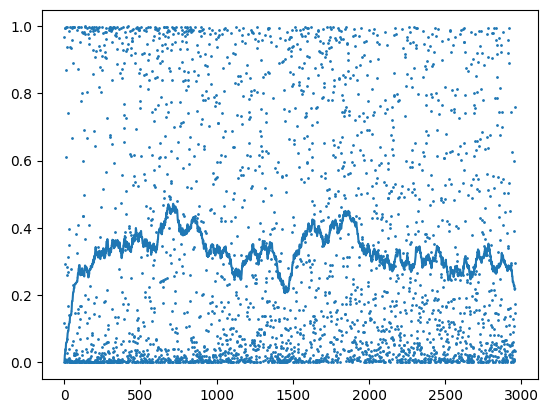

In [33]:
import matplotlib.pyplot as plt

xs = list(range(len(ppo_trainer.rolling_rewards)))
ys = ppo_trainer.rolling_rewards

window_size = 100
smoothed_ys = [sum(ys[max(0, idx-window_size):idx])/window_size for idx, _ in enumerate(ys)]

plt.scatter(xs, ys, s=1)
plt.plot(smoothed_ys)

In [47]:
inputs = tokenizer('I went for a walk one day and', return_tensors='pt')
outputs = reference.generate(inputs.input_ids.to(model.device), max_length=100, do_sample=True)
text = tokenizer.batch_decode(outputs)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
